In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Prepare Dataset

In [2]:
train_dataset_path = './dataset/train_preprocess.tsv'
valid_dataset_path = './dataset/valid_preprocess.tsv'
test_dataset_path = './dataset/test_preprocess.tsv'

In [3]:
train_df = pd.read_csv(train_dataset_path, sep='\t', header=None)
valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None)
test_df = pd.read_csv(test_dataset_path, sep='\t', header=None)

train_df.columns = ['text', 'label']
valid_df.columns = ['text', 'label']
test_df.columns = ['text', 'label']

In [4]:
train_df.head(10)

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


In [5]:
def get_label_idx(label):
    if label == 'positive':
        return 2
    if label == 'negative':
        return 1
    if label == 'neutral':
        return 0
train_df['label'] = train_df['label'].apply(get_label_idx)
valid_df['label'] = valid_df['label'].apply(get_label_idx)
test_df['label'] = test_df['label'].apply(get_label_idx)

In [6]:
jumlah_positives = (train_df['label'] == 2).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (train_df['label'] == 1).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 6416
Jumlah review negatif: 3436


In [7]:
train_df.head(10)

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,2
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0
2,lokasi strategis di jalan sumatera bandung . t...,2
3,betapa bahagia nya diri ini saat unboxing pake...,2
4,duh . jadi mahasiswa jangan sombong dong . kas...,1
5,"makanan beragam , harga makanan di food stall ...",2
6,pakai kartu kredit bca tidak untung malah rugi...,1
7,"tempat unik , bagus buat foto , makanan enak ,...",2
8,saya bersama keluarga baru saja menikmati peng...,2
9,bersyukur,2


## Preprocessing

In [8]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))
print(len(stop_words))

print (stop_words)

757
{'mengatakan', 'keduanya', 'harusnya', 'melainkan', 'naik', 'seharusnya', 'akankah', 'bukanlah', 'dipunyai', 'setibanya', 'yakni', 'kan', 'berbagai', 'mengungkapkan', 'bukankah', 'asalkan', 'kepada', 'hanya', 'jelaskan', 'mempertanyakan', 'melihat', 'meminta', 'teringat', 'agaknya', 'tiba-tiba', 'mendatangkan', 'jawaban', 'olehnya', 'misal', 'tanpa', 'agak', 'sebuah', 'diri', 'macam', 'sedang', 'bahwasanya', 'menghendaki', 'kelima', 'kira-kira', 'sementara', 'artinya', 'apaan', 'berdatangan', 'mampukah', 'pentingnya', 'itulah', 'bagaimana', 'menyampaikan', 'bisa', 'ibu', 'berkeinginan', 'kedua', 'menyiapkan', 'bertanya-tanya', 'ataupun', 'anda', 'beginikah', 'kiranya', 'sambil', 'bila', 'sebesar', 'entah', 'berlalu', 'lagi', 'sekarang', 'berkenaan', 'sekaligus', 'serupa', 'dimintai', 'umum', 'mula', 'menanya', 'seperti', 'meyakinkan', 'kinilah', 'di', 'inikah', 'masing-masing', 'memihak', 'demi', 'mengenai', 'menurut', 'atas', 'sebutlah', 'amat', 'keterlaluan', 'panjang', 'tuturnya

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Case Folding dan Tokenizing

In [27]:

import string 
import re #regex library

# import word_tokenize & FreqDist from NLTK
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist


# ------ Tokenizing ---------

def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
                
train_df['text'] = train_df['text'].apply(remove_tweet_special)
valid_df['text'] = valid_df['text'].apply(remove_tweet_special)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

train_df['text'] = train_df['text'].apply(remove_number)
valid_df['text'] = valid_df['text'].apply(remove_number)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

train_df['text'] = train_df['text'].apply(remove_punctuation)
valid_df['text'] = valid_df['text'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

train_df['text'] = train_df['text'].apply(remove_whitespace_LT)
valid_df['text'] = valid_df['text'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

train_df['text'] = train_df['text'].apply(remove_whitespace_multiple)
valid_df['text'] = valid_df['text'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

train_df['text'] = train_df['text'].apply(remove_singl_char)
valid_df['text'] = valid_df['text'].apply(remove_singl_char)

# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

train_df['tweet_tokens'] = train_df['text'].apply(word_tokenize_wrapper)
valid_df['tweet_tokens'] = valid_df['text'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n') 
print(train_df['tweet_tokens'].head())
print('\n\n\n')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenizing Result : 

0    [warung, ini, dimiliki, oleh, pengusaha, pabri...
1    [mohon, ulama, lurus, dan, mmbri, hujjah, part...
2    [lokasi, strategis, di, jalan, sumatera, bandu...
3    [betapa, bahagia, nya, diri, ini, saat, unboxi...
4    [duh, jadi, mahasiswa, jangan, sombong, dong, ...
Name: tweet_tokens, dtype: object






In [28]:

# NLTK calc frequency distribution
def freqDist_wrapper(text):
    return FreqDist(text)

train_df['tweet_tokens_fdist'] = train_df['tweet_tokens'].apply(freqDist_wrapper)
valid_df['tweet_tokens_fdist'] = valid_df['tweet_tokens'].apply(freqDist_wrapper)

print('Frequency Tokens : \n') 
print(train_df['tweet_tokens_fdist'].head().apply(lambda x : x.most_common()))
print('\n\n\n')
print(valid_df['tweet_tokens_fdist'].head().apply(lambda x : x.most_common()))

Frequency Tokens : 

0    [(tahu, 5), (yang, 3), (warung, 2), (dipadu, 2...
1    [(mohon, 1), (ulama, 1), (lurus, 1), (dan, 1),...
2    [(nya, 3), (di, 2), (lokasi, 1), (strategis, 1...
3    [(nya, 2), (betapa, 1), (bahagia, 1), (diri, 1...
4    [(mahasiswa, 2), (tidak, 2), (politik, 2), (du...
Name: tweet_tokens_fdist, dtype: object




0    [(meski, 1), (masa, 1), (kampanye, 1), (sudah,...
1                              [(tidak, 1), (enak, 1)]
2    [(goreng, 3), (nasi, 3), (makanan, 2), (kami, ...
3    [(alun, 2), (padang, 2), (dan, 2), (lokasi, 1)...
4    [(yang, 2), (harus, 2), (di, 2), (betapa, 1), ...
Name: tweet_tokens_fdist, dtype: object


### Remove Stopwords

In [29]:
# ----------------------- get stopword from NLTK stopword -------------------------------
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')


# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah'])

# ----------------------- add stopword from txt file ------------------------------------
# read txt stopword using pandas
txt_stopword = pd.read_csv("stopwords.txt", names= ["stopwords"], header = None)

# convert stopword string to list & append additional stopword
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))

# ---------------------------------------------------------------------------------------

# convert list to dictionary
list_stopwords = set(list_stopwords)


#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

train_df['tweet_tokens_WSW'] = train_df['tweet_tokens'].apply(stopwords_removal)
valid_df['tweet_tokens_WSW'] = valid_df['tweet_tokens'].apply(stopwords_removal) 


print(train_df['tweet_tokens_WSW'].head())

0    [warung, dimiliki, pengusaha, pabrik, puluhan,...
1    [mohon, ulama, lurus, mmbri, hujjah, partai, d...
2    [lokasi, strategis, jalan, sumatera, bandung, ...
3    [betapa, bahagia, unboxing, paket, barang, bag...
4    [duh, mahasiswa, sombong, kasih, kartu, kuning...
Name: tweet_tokens_WSW, dtype: object


### Normalization

Normalization digunakan untuk menyeragamkan term yang memiliki makna sama namun penulisanya berbeda, bisa diakibatkan kesalahan penulisan, penyingkatan kata, ataupun “bahasa gaul”.

In [22]:
import csv

# Baca isi file teks
with open('kamus-alay.txt', 'r') as txt_file:
    # Baca teks dan hapus karakter '{' dan '}' dari awal dan akhir teks
    data = txt_file.read().strip('{}')
    # Split teks berdasarkan koma dan spasi
    pairs = data.split(', ')
    # Buat list untuk menyimpan pasangan kata sebelum dan sesudah
    rows = [['before', 'after']]
    for pair in pairs:
        # Temukan indeks pertama tanda titik dua dalam pasangan kata
        colon_index = pair.find(': ')
        # Bagi pasangan kata berdasarkan tanda titik dua pertama
        before = pair[:colon_index]
        after = pair[colon_index + 2:]
        # Hapus tanda kutip ganda dari kata sebelum dan sesudah
        before = before.strip('"')
        after = after.strip('"')
        # Tambahkan pasangan kata ke list
        rows.append([before, after])

# Tulis ke file CSV
with open('kamus-alay.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(rows)

print("File CSV telah dibuat.")


File CSV telah dibuat.


In [30]:
normalizad_word = pd.read_csv("kamus-alay.csv")

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

train_df['tweet_normalized'] = train_df['tweet_tokens_WSW'].apply(normalized_term)
valid_df['tweet_normalized'] = valid_df['tweet_tokens_WSW'].apply(normalized_term)

train_df['tweet_normalized'].head(10)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_3152\3930806163.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalizad_word_dict:
C:\Users\lenovo\AppData\Local\Temp\ipykernel_3152\3930806163.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalizad_word_dict[row[0]] = row[1]


0    [warung, dimiliki, pengusaha, pabrik, puluhan,...
1    [mohon, ulama, lurus, mmbri, hujjah, partai, d...
2    [lokasi, strategis, jalan, sumatera, bandung, ...
3    [betapa, bahagia, unboxing, paket, barang, bag...
4    [duh, mahasiswa, sombong, kasih, kartu, kuning...
5    [makanan, beragam, harga, makanan, food, stall...
6           [pakai, kartu, kredit, baca, untung, rugi]
7    [unik, bagus, foto-foto, makanan, enak, pegawa...
8    [keluarga, menikmati, pengalaman, kuliner, men...
9                                          [bersyukur]
Name: tweet_normalized, dtype: object

### Stemming

In [31]:
# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter


# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in train_df['tweet_normalized']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

train_df['tweet_tokens_stemmed'] = train_df['tweet_normalized'].swifter.apply(get_stemmed_term)
print(train_df['tweet_tokens_stemmed'])

c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


16643
------------------------
warung : warung
dimiliki : milik
pengusaha : usaha
pabrik : pabrik
puluhan : puluh
terkenal : kenal
putih : putih
bandung : bandung
berkualitas : kualitas
dipadu : padu
keahlian : ahli
memasak : masak
kretivitas : kretivitas
menyajikan : saji
menu : menu
utama : utama
berbahan : bahan
ditambah : tambah
ayam : ayam
selera : selera
indonesia : indonesia
harga : harga
terjangkau : jangkau
lewatkan : lewat
bletoka : bletoka
kalah : kalah
asli : asli
tegal : tegal
mohon : mohon
ulama : ulama
lurus : lurus
mmbri : mmbri
hujjah : hujjah
partai : partai
diwlh : diwlh
suara : suara
islam : islam
pecahpecah : pecahpecah
lokasi : lokasi
strategis : strategis
jalan : jalan
sumatera : sumatera
nyaman : nyaman
sofa : sofa
lantai : lantai
paella : paella
enak : enak
pas : pas
dimakan : makan
minum : minum
bir : bir
dingin-dingin : dingin
appetiser : appetiser
enakenak : enakenak
betapa : betapa
bahagia : bahagia
unboxing : unboxing
paket : paket
barang : barang
bagus : 

Pandas Apply: 100%|██████████| 11000/11000 [00:00<00:00, 123670.40it/s]

0        [warung, milik, usaha, pabrik, puluh, kenal, p...
1        [mohon, ulama, lurus, mmbri, hujjah, partai, d...
2        [lokasi, strategis, jalan, sumatera, bandung, ...
3        [betapa, bahagia, unboxing, paket, barang, bag...
4        [duh, mahasiswa, sombong, kasih, kartu, kuning...
                               ...                        
10995                                             [kecewa]
10996    [enak, masakan, kepiting, senang, pilih, kepit...
10997                      [hormat, partaipartai, koalisi]
10998    [pagi, pagi, tol, pasteur, macet, parah, jengkel]
10999    [belanja, yogya, riau, junction, kali, lihat, ...
Name: tweet_tokens_stemmed, Length: 11000, dtype: object


In [32]:
term_dict_valid = {}

for document in valid_df['tweet_normalized']:
    for term in document:
        if term not in term_dict_valid:
            term_dict_valid[term] = ' '
            
print(len(term_dict_valid))
print("------------------------")

for term in term_dict_valid:
    term_dict_valid[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict_valid[term])
    
print(term_dict_valid)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict_valid[term] for term in document]

valid_df['tweet_tokens_stemmed'] = valid_df['tweet_normalized'].swifter.apply(get_stemmed_term)
print(valid_df['tweet_tokens_stemmed'])

4935
------------------------
kampanye : kampanye
selesai : selesai
berarti : arti
habis : habis
upaya : upaya
mengerek : kerek
tingkat : tingkat
kedipilihan : pilih
elektabilitas : elektabilitas
enak : enak
restoran : restoran
menawarkan : tawar
makanan : makan
sunda : sunda
memesan : mes
ayam : ayam
goreng : goreng
kangkung : kangkung
sayur : sayur
asam : asam
ikan : ikan
gurame : gurame
bakar : bakar
nasi : nasi
karedok : karedok
tempe : tempe
putih : putih
merah : merah
etc : etc
minuman : minum
tawarkan : tawar
variatif : variatif
harga : harga
murah : murah
dewasa : dewasa
anak-anak : anak
menghabiskan : habis
lokasi : lokasi
alun : alun
masakan : masakan
padang : padang
terkenal : kenal
kepala : kepala
kakap : kakap
gule : gule
pesan : pesan
bungkus : bungkus
berisikan : risi
rendang : rendang
pop : pop
perkedel : perkedel
porsi : porsi
mengenyangkan : kenyang
betapa : betapa
bejad : bejad
kader : kader
gerindra : gerindra
anggota : anggota
dprd : dprd
mencabuli : cabul
sampai :

Pandas Apply: 100%|██████████| 1260/1260 [00:00<00:00, 123636.05it/s]

0       [kampanye, selesai, arti, habis, upaya, kerek,...
1                                                  [enak]
2       [restoran, tawar, makan, sunda, mes, ayam, gor...
3       [lokasi, alun, alun, masakan, padang, kenal, k...
4       [betapa, bejad, kader, gerindra, anggota, dprd...
                              ...                        
1255            [film, tncfu, cocok, tonton, suka, sadis]
1256             [indihome, mahal, bayar, tangan, lambat]
1257    [be, dek, gea, cowok, cupu, takut, pacar, paca...
1258    [valen, kualitas, konentator, didik, jebret, j...
1259    [restoran, pilih, buka, puasa, minggu, layan, ...
Name: tweet_tokens_stemmed, Length: 1260, dtype: object


In [34]:
train_df.to_csv("Text_PreprocessingV2_Train.csv")
valid_df.to_csv("Text_PreprocessingV2_Valid.csv")

## TFiDF

In [50]:
# Membaca file CSV dengan hanya menggunakan kolom "label" dan "tweet_tokens_stemmed"
train_df_preprocessed = pd.read_csv("Text_PreprocessingV2_Train.csv", usecols=["label", "tweet_tokens_stemmed"])
valid_df_preprocessed = pd.read_csv("Text_PreprocessingV2_Valid.csv", usecols=["label", "tweet_tokens_stemmed"])

# Melakukan penamaan kolom
train_df_preprocessed.columns = ["label", "tweet_tokens_stemmed"]
valid_df_preprocessed.columns = ["label", "tweet_tokens_stemmed"]

# Menggabungkan dataset train dan validasi
merged_df = pd.concat([train_df_preprocessed, valid_df_preprocessed], ignore_index=True)

# Menyimpan dataframe ke dalam file CSV
merged_df.to_csv("Text_PreprocessingV2_Merged_Dataset.csv", index=False)

In [52]:
print(len(merged_df))

12260


In [53]:
# convert list formated string to list
import ast

def convert_text_list(texts):
    texts = ast.literal_eval(texts)
    return [text for text in texts]

merged_df["tweet_list"] = merged_df["tweet_tokens_stemmed"].apply(convert_text_list)


print(merged_df["tweet_list"][90])

print("\ntype : ", type(merged_df["tweet_list"][90]))

['restoran', 'letak', 'stategis', 'jalan', 'dago', 'belah', 'hotel', 'holiday', 'inn', 'sesuai', 'judul', 'restoran', 'sedia', 'menu', 'masakan', 'aceh', 'favorit', 'mi', 'aceh', 'harga', 'standar', 'mahal', 'lupa', 'coba', 'roti', 'canai']

type :  <class 'list'>


### TF From Scratch

Term Frequency merupakan frekuensi kemunculan term i pada dokumen j dibagi dengan total term pada dokumen j. Ditulis dalam bentuk,

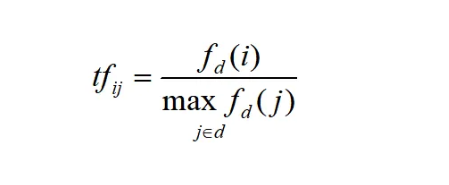

In [54]:
def calc_TF(document):
    # Counts the number of times the word appears in review
    TF_dict = {}
    for term in document:
        if term in TF_dict:
            TF_dict[term] += 1
        else:
            TF_dict[term] = 1
    # Computes tf for each word
    for term in TF_dict:
        TF_dict[term] = TF_dict[term] / len(document)
    return TF_dict

merged_df["TF_dict"] = merged_df['tweet_list'].apply(calc_TF)

merged_df["TF_dict"].head()

0    {'warung': 0.06451612903225806, 'milik': 0.032...
1    {'mohon': 0.1, 'ulama': 0.1, 'lurus': 0.1, 'mm...
2    {'lokasi': 0.058823529411764705, 'strategis': ...
3    {'betapa': 0.125, 'bahagia': 0.125, 'unboxing'...
4    {'duh': 0.0625, 'mahasiswa': 0.125, 'sombong':...
Name: TF_dict, dtype: object

In [55]:
# Check TF result
index = 10

print('%20s' % "term", "\t", "TF\n")
for key in merged_df["TF_dict"][index]:
    print('%20s' % key, "\t", merged_df["TF_dict"][index][key])

                term 	 TF

             simcard 	 0.07142857142857142
             indosat 	 0.07142857142857142
             inaktiv 	 0.07142857142857142
            garagara 	 0.07142857142857142
                lupa 	 0.07142857142857142
                 isi 	 0.07142857142857142
               pulsa 	 0.07142857142857142
               kabar 	 0.07142857142857142
               aktif 	 0.07142857142857142
               pinda 	 0.07142857142857142
               pasca 	 0.07142857142857142
               bayar 	 0.07142857142857142
               ribet 	 0.07142857142857142
              banget 	 0.07142857142857142


### IDF From Scratch

IDF berfungsi mengurangi bobot suatu term jika kemunculannya banyak tersebar diseluruh dokumen, dituliskan dalam bentuk,
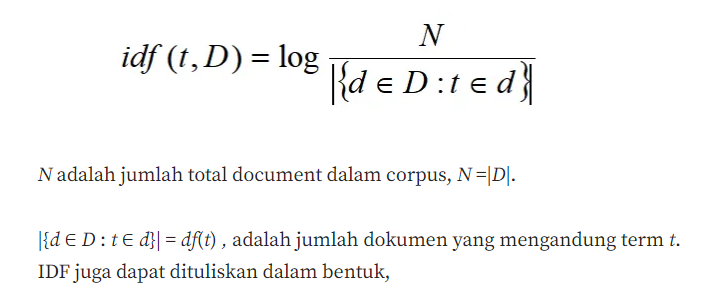

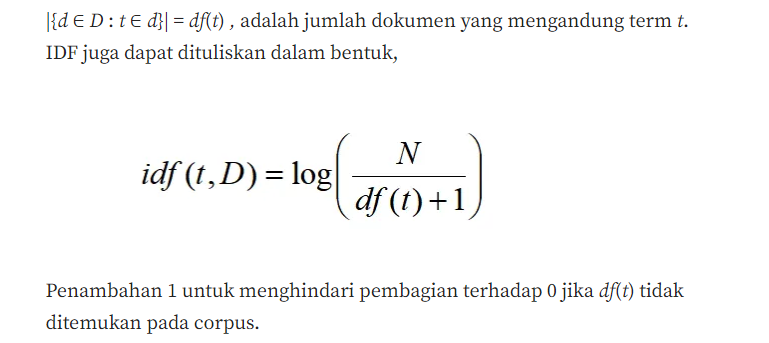

In [56]:
def calc_DF(tfDict):
    count_DF = {}
    # Run through each document's tf dictionary and increment countDict's (term, doc) pair
    for document in tfDict:
        for term in document:
            if term in count_DF:
                count_DF[term] += 1
            else:
                count_DF[term] = 1
    return count_DF

DF = calc_DF(merged_df["TF_dict"])

In [57]:
DF

{'warung': 160,
 'milik': 240,
 'usaha': 56,
 'pabrik': 6,
 'puluh': 30,
 'kenal': 255,
 'putih': 76,
 'bandung': 1617,
 'kualitas': 241,
 'padu': 63,
 'ahli': 6,
 'masak': 105,
 'kretivitas': 1,
 'saji': 652,
 'menu': 1487,
 'utama': 118,
 'bahan': 70,
 'tambah': 380,
 'ayam': 663,
 'selera': 141,
 'indonesia': 455,
 'harga': 2060,
 'jangkau': 478,
 'lewat': 79,
 'bletoka': 1,
 'kalah': 125,
 'asli': 113,
 'tegal': 1,
 'mohon': 49,
 'ulama': 29,
 'lurus': 9,
 'mmbri': 1,
 'hujjah': 1,
 'partai': 126,
 'diwlh': 1,
 'suara': 87,
 'islam': 114,
 'pecahpecah': 1,
 'lokasi': 669,
 'strategis': 206,
 'jalan': 859,
 'sumatera': 15,
 'nyaman': 983,
 'sofa': 28,
 'lantai': 167,
 'paella': 2,
 'enak': 3128,
 'pas': 612,
 'makan': 4395,
 'minum': 633,
 'bir': 22,
 'dingin': 220,
 'appetiser': 2,
 'enakenak': 106,
 'betapa': 7,
 'bahagia': 25,
 'unboxing': 1,
 'paket': 157,
 'barang': 114,
 'bagus': 776,
 'tetap': 6,
 'beli': 348,
 'duh': 9,
 'mahasiswa': 98,
 'sombong': 24,
 'kasih': 258,
 'kart

In [58]:
n_document = len(merged_df)

def calc_IDF(__n_document, __DF):
    IDF_Dict = {}
    for term in __DF:
        IDF_Dict[term] = np.log(__n_document / (__DF[term] + 1))
    return IDF_Dict
  
#Stores the idf dictionary
IDF = calc_IDF(n_document, DF)

In [59]:
#calc TF-IDF
def calc_TF_IDF(TF):
    TF_IDF_Dict = {}
    #For each word in the review, we multiply its tf and its idf.
    for key in TF:
        TF_IDF_Dict[key] = TF[key] * IDF[key]
    return TF_IDF_Dict

#Stores the TF-IDF Series
merged_df["TF-IDF_dict"] = merged_df["TF_dict"].apply(calc_TF_IDF)

In [60]:
# Check TF-IDF result
index = 90

print('%20s' % "term", "\t", '%10s' % "TF", "\t", '%20s' % "TF-IDF\n")
for key in merged_df["TF-IDF_dict"][index]:
    print('%20s' % key, "\t", merged_df["TF_dict"][index][key] ,"\t" , merged_df["TF-IDF_dict"][index][key])


                term 	         TF 	              TF-IDF

            restoran 	 0.07692307692307693 	 0.18730399495549174
               letak 	 0.038461538461538464 	 0.13154368393013974
            stategis 	 0.038461538461538464 	 0.3087616480142428
               jalan 	 0.038461538461538464 	 0.10219864693240958
                dago 	 0.038461538461538464 	 0.15411251684731092
               belah 	 0.038461538461538464 	 0.19120945973076486
               hotel 	 0.038461538461538464 	 0.14895514093583756
             holiday 	 0.038461538461538464 	 0.30017920373292706
                 inn 	 0.038461538461538464 	 0.30017920373292706
              sesuai 	 0.038461538461538464 	 0.13846025683327448
               judul 	 0.038461538461538464 	 0.26650732921931547
               sedia 	 0.038461538461538464 	 0.12059906866632146
                menu 	 0.038461538461538464 	 0.08111188438835251
             masakan 	 0.038461538461538464 	 0.12921761012387817
                aceh 

Sekarang kita jadikan Series TF-IDF menjadi TF-IDF vector data berbentuk Sparse Matrix dengan dimensi (n_samples, n_feature), n_feature yang akan kita gunakan adalah top 50 term dengan TF-IDF terbesar, sedangkan n_samples sebanyak 23225 row data tweet.

In [61]:
# sort descending by value for DF dictionary 
sorted_DF = sorted(DF.items(), key=lambda kv: kv[1], reverse=True)[:50]

# Create a list of unique words from sorted dictionay `sorted_DF`
unique_term = [item[0] for item in sorted_DF]

def calc_TF_IDF_Vec(__TF_IDF_Dict):
    TF_IDF_vector = [0.0] * len(unique_term)

    # For each unique word, if it is in the review, store its TF-IDF value.
    for i, term in enumerate(unique_term):
        if term in __TF_IDF_Dict:
            TF_IDF_vector[i] = __TF_IDF_Dict[term]
    return TF_IDF_vector

merged_df["TF_IDF_Vec"] = merged_df["TF-IDF_dict"].apply(calc_TF_IDF_Vec)

print("print first row matrix TF_IDF_Vec Series\n")
print(merged_df["TF_IDF_Vec"][0])

print("\nmatrix size : ", len(merged_df["TF_IDF_Vec"][0]))

print first row matrix TF_IDF_Vec Series

[0.0, 0.0, 0.05752098801934656, 0.06532745522166984, 0.13605864478046226, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09405855032302479, 0.09459742194237972, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10459343909933184, 0.0, 0.0, 0.0, 0.0, 0.10618078709599407, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

matrix size :  50


In [62]:
# Convert Series to List
TF_IDF_Vec_List = np.array(merged_df["TF_IDF_Vec"].to_list())

# Sum element vector in axis=0 
sums = TF_IDF_Vec_List.sum(axis=0)

data = []

for col, term in enumerate(unique_term):
    data.append((term, sums[col]))
    
ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking.sort_values('rank', ascending=False)

,term,rank
0,makan,396.701154
1,enak,333.544314
5,banget,255.245278
2,harga,235.962705
12,suka,204.429969
6,layan,203.795428
3,bandung,191.707942
4,menu,190.536497
20,orang,185.378083
8,pilih,182.832514


### TF-IDF scikit-learn

In [64]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
merged_df["tweet_join"] = merged_df["tweet_tokens_stemmed"].apply(join_text_list)

merged_df["tweet_join"].head()

0    warung milik usaha pabrik puluh kenal putih ba...
1    mohon ulama lurus mmbri hujjah partai diwlh su...
2    lokasi strategis jalan sumatera bandung nyaman...
3    betapa bahagia unboxing paket barang bagus tet...
4    duh mahasiswa sombong kasih kartu kuning ajar ...
Name: tweet_join, dtype: object

In [71]:
##unigram
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize

max_features = 1000

# calc TF vector
cvect = CountVectorizer(max_features=max_features)
TF_vector = cvect.fit_transform(merged_df["tweet_join"])

# normalize TF vector
normalized_TF_vector = normalize(TF_vector, norm='l1', axis=1)

# calc IDF
tfidf = TfidfVectorizer(max_features=max_features, smooth_idf=False)
tfs = tfidf.fit_transform(merged_df["tweet_join"])
IDF_vector = tfidf.idf_

# hitung TF x IDF sehingga dihasilkan TFIDF matrix / vector
tfidf_mat = normalized_TF_vector.multiply(IDF_vector).toarray()

In [72]:
len(tfidf.get_feature_names_out()), tfidf.get_feature_names_out()[0:20]

(1000,
 array(['ac', 'acara', 'aceh', 'ada', 'adem', 'aduh', 'agam', 'agama',
        'ah', 'ahok', 'air', 'ajak', 'ajar', 'akal', 'akses', 'aku', 'ala',
        'alam', 'alami', 'alas'], dtype=object))

In [75]:
## generate unigram, bigram, and trigram

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize

max_features = 1000


def generate_tfidf_mat(min_gram, max_gram):
    cvect = CountVectorizer(max_features=max_features, ngram_range=(min_gram, max_gram))
    counts = cvect.fit_transform(merged_df["tweet_join"])

    normalized_counts = normalize(counts, norm='l1', axis=1)

    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(min_gram, max_gram), smooth_idf=False)
    tfs = tfidf.fit_transform(merged_df["tweet_join"])

    tfidf_mat = normalized_counts.multiply(tfidf.idf_).toarray()
    
    TF = normalized_counts.toarray()
    IDF = tfidf.idf_
    TF_IDF = tfidf_mat
    return TF, IDF, TF_IDF, tfidf.get_feature_names_out()

# ngram_range (1, 1) to use unigram only
tf_mat_unigram, idf_mat_unigram, tfidf_mat_unigram, terms_unigram = generate_tfidf_mat(1,1)

# ngram_range (2, 2) to use bigram only
tf_mat_bigram, idf_mat_bigram, tfidf_mat_bigram, terms_bigram = generate_tfidf_mat(2,2)

# ngram_range (3, 3) to use trigram only
tf_mat_trigram, idf_mat_trigram, tfidf_mat_trigram, terms_trigram = generate_tfidf_mat(3,3)

# ---------- check sparse data -------------------
idx_sample = 0

print("Show TFIDF sample ke-" + str(idx_sample), "\n")
print(merged_df["tweet_tokens_stemmed"][idx_sample], "\n")

print("\t\t\t", "TF", "\t\t", "IDF", "\t\t", "TF-IDF", "\t", "Term\n")
for i, item in enumerate(zip(tf_mat_unigram[idx_sample], idf_mat_unigram, tfidf_mat_unigram[idx_sample], terms_unigram)):
    if(item[2] != 0.0):
        print ("array position " + str(i) + "\t", 
               "%.6f" % item[0], "\t", 
               "%.6f" % item[1], "\t", 
               "%.6f" % item[2], "\t", 
               item[3])

Show TFIDF sample ke-0 

['warung', 'milik', 'usaha', 'pabrik', 'puluh', 'kenal', 'putih', 'bandung', 'kualitas', 'padu', 'ahli', 'masak', 'padu', 'kretivitas', 'warung', 'saji', 'menu', 'utama', 'bahan', 'tambah', 'menu', 'ayam', 'selera', 'indonesia', 'harga', 'jangkau', 'lewat', 'bletoka', 'kalah', 'asli', 'tegal'] 

			 TF 		 IDF 		 TF-IDF 	 Term

array position 52	 0.038462 	 5.686709 	 0.218720 	 asli
array position 56	 0.038462 	 3.917322 	 0.150666 	 ayam
array position 64	 0.038462 	 6.165602 	 0.237139 	 bahan
array position 75	 0.038462 	 3.025769 	 0.116376 	 bandung
array position 292	 0.038462 	 2.783636 	 0.107063 	 harga
array position 325	 0.038462 	 4.293800 	 0.165146 	 indonesia
array position 354	 0.038462 	 4.244486 	 0.163249 	 jangkau
array position 386	 0.038462 	 5.585783 	 0.214838 	 kalah
array position 423	 0.038462 	 4.872834 	 0.187417 	 kenal
array position 464	 0.038462 	 4.929300 	 0.189588 	 kualitas
array position 504	 0.038462 	 6.044649 	 0.232487 

In [76]:
## save tfidf unigram
def get_TF_unigram(row):
    idx = row.name
    return [tf for tf in tf_mat_unigram[idx] if tf != 0.0]

merged_df["TF_UNIGRAM"] = merged_df.apply(get_TF_unigram, axis=1)

def get_IDF_unigram(row):
    idx = row.name
    return [item[1] for item in zip(tf_mat_unigram[idx], idf_mat_unigram) if item[0] != 0.0]

merged_df["IDF_UNIGRAM"] = merged_df.apply(get_IDF_unigram, axis=1)

def get_TFIDF_unigram(row):
    idx = row.name
    return [tfidf for tfidf in tfidf_mat_unigram[idx] if tfidf != 0.0]

merged_df["TFIDF_UNIGRAM"] = merged_df.apply(get_TFIDF_unigram, axis=1)

merged_df[["tweet_tokens_stemmed", "TF_UNIGRAM", "IDF_UNIGRAM", "TFIDF_UNIGRAM"]].head()

# save TFIDF Unigram to Excel

merged_df[["tweet_tokens_stemmed", "TF_UNIGRAM", "IDF_UNIGRAM", "TFIDF_UNIGRAM"]].to_excel("TFIDF_Unigram.xlsx")

In [77]:
def get_TF_bigram(row):
    idx = row.name
    return [tf for tf in tf_mat_bigram[idx] if tf != 0.0]

merged_df["TF_BIGRAM"] = merged_df.apply(get_TF_bigram, axis=1)

def get_IDF_bigram(row):
    idx = row.name
    return [item[1] for item in zip(tf_mat_bigram[idx], idf_mat_bigram) if item[0] != 0.0]

merged_df["IDF_BIGRAM"] = merged_df.apply(get_IDF_bigram, axis=1)

def get_TFIDF_bigram(row):
    idx = row.name
    return [tfidf for tfidf in tfidf_mat_bigram[idx] if tfidf != 0.0]

merged_df["TFIDF_BIGRAM"] = merged_df.apply(get_TFIDF_bigram, axis=1)

def get_Term_bigram(row):
    idx = row.name
    return [item[1] for item in zip(tf_mat_bigram[idx], terms_bigram) if item[0] != 0.0]

merged_df["TWEET_BIGRAM"] = merged_df.apply(get_Term_bigram, axis=1)

merged_df[["TWEET_BIGRAM", "TF_BIGRAM", "IDF_BIGRAM", "TFIDF_BIGRAM"]].head()


# save TFIDF Bigram to Excel

merged_df[["TWEET_BIGRAM", "TF_BIGRAM", "IDF_BIGRAM", "TFIDF_BIGRAM"]].to_excel("TFIDF_Bigram.xlsx")


In [78]:
def get_TF_trigram(row):
    idx = row.name
    return [tf for tf in tf_mat_trigram[idx] if tf != 0.0]

merged_df["TF_trigram"] = merged_df.apply(get_TF_trigram, axis=1)

def get_IDF_trigram(row):
    idx = row.name
    return [item[1] for item in zip(tf_mat_trigram[idx], idf_mat_trigram) if item[0] != 0.0]

merged_df["IDF_trigram"] = merged_df.apply(get_IDF_trigram, axis=1)

def get_TFIDF_trigram(row):
    idx = row.name
    return [tfidf for tfidf in tfidf_mat_trigram[idx] if tfidf != 0.0]

merged_df["TFIDF_trigram"] = merged_df.apply(get_TFIDF_trigram, axis=1)

def get_Term_trigram(row):
    idx = row.name
    return [item[1] for item in zip(tf_mat_trigram[idx], terms_trigram) if item[0] != 0.0]

merged_df["TWEET_TRIGRAM"] = merged_df.apply(get_Term_trigram, axis=1)

merged_df[["TWEET_TRIGRAM", "TF_trigram", "IDF_trigram", "TFIDF_trigram"]].head()


# save TFIDF Trigram to Excel

merged_df[["TWEET_TRIGRAM", "TF_trigram", "IDF_trigram", "TFIDF_trigram"]].to_excel("TFIDF_Trigram.xlsx")

In [79]:
from scipy import sparse

# save sparse matrix unigram, bigram and trigram to .npz file
sparse.save_npz("tfidf_mat_unigram.npz", sparse.csr_matrix(tfidf_mat_unigram))
sparse.save_npz("tfidf_mat_bigram.npz", sparse.csr_matrix(tfidf_mat_bigram))
sparse.save_npz("tfidf_mat_trigram.npz", sparse.csr_matrix(tfidf_mat_trigram))

## Build and Compile Model

In [83]:
# ---------------------- Get Sparse Matrix & Tags , Unigram, BIgram and Trigram ------------------
def get_sparse_n_tags(file_names, dataset_name):
    
    # load preprocessed dataset as dataframe
    LABEL_DATA = pd.read_csv(dataset_name, encoding = "ISO-8859-1", usecols=["label"])
    tags = LABEL_DATA.label
    
    # load sparse matrix
    unigram = sparse.load_npz(file_names[0]).toarray()
    bigram = sparse.load_npz(file_names[1]).toarray()
    trigram = sparse.load_npz(file_names[2]).toarray()
    
    return [unigram, bigram, trigram, tags]


sparse_file_names = [
                    "tfidf_mat_unigram.npz",
                    "tfidf_mat_bigram.npz",
                    "tfidf_mat_trigram.npz"]
preprocessed_dataset_name = "Text_PreprocessingV2_Merged_Dataset.csv"

sparse_unigram, sparse_bigram, sparse_trigram, tags = \
                        get_sparse_n_tags(sparse_file_names, preprocessed_dataset_name)

In [84]:
from sklearn.model_selection import train_test_split
# ---------------------------- SPLIT DATASET -----------------------------------------------
def split_dataset(sparse, tags, split_ratio):
    # split dataset 
    return train_test_split(sparse, tags, test_size=split_ratio, random_state=42) 


sparse_unigram_train, sparse_unigram_test, tags_train, tags_test = split_dataset(sparse_unigram, tags, 0.25)
sparse_bigram_train, sparse_bigram_test, tags_train, tags_test = split_dataset(sparse_bigram, tags, 0.25)
sparse_trigram_train, sparse_trigram_test, tags_train, tags_test = split_dataset(sparse_trigram, tags, 0.25)

In [85]:
# -------------- define custom metric : precission, recall and F1 score ---------------------
from keras import metrics
from keras import backend as K


def rec(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def prec(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = prec(y_true, y_pred)
    recall = rec(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [108]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D
from keras.layers import Embedding
from keras import metrics
import tensorflow.keras.backend as K

def get_cnn_model(max_len = 1000):  
    model = Sequential()
    
    model.add(Embedding(1000,
                        16,
                        input_shape=(max_len,)))
    # model.add(Dropout(0.2))
    model.add(Conv1D(64,
                    3,
                    padding='valid',
                    activation='relu',
                    strides=1))
    # model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(3))
    model.add(Dropout(0.2))
    model.add(Activation('softmax'))
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy', rec, prec])
    return model

def check_model(model,x,y): 
    #return model.fit(x,y,batch_size=63,epochs=20,verbose=1,validation_split=0.15)
    return model.fit(x, y, verbose=1, validation_split=0.2)

## Train Model

In [109]:
from scikeras.wrappers import KerasClassifier

# ----------------------------- START TRAINING MODEL ------------------------------
EPOCHS = 25
BATCH_SIZE = 6


print("--------------------------------------------------------------------------")
print(" TRAIN UNIGRAM MODEL ")
estimator_unigram = KerasClassifier(model=get_cnn_model, max_len = sparse_unigram_train.shape[1], epochs=EPOCHS, batch_size=BATCH_SIZE)
history_unigram = check_model(estimator_unigram,sparse_unigram_train, tags_train.ravel())

print("\n\n\n")
print("--------------------------------------------------------------------------")
print(" TRAIN BIGRAM MODEL ")
estimator_bigram = KerasClassifier(model=get_cnn_model, max_len = sparse_bigram_train.shape[1], epochs=EPOCHS, batch_size=BATCH_SIZE)
history_bigram = check_model(estimator_bigram,sparse_bigram_train, tags_train.ravel())

print("\n\n\n")
print("--------------------------------------------------------------------------")
print(" TRAIN TRIGRAM MODEL ")
estimator_trigram = KerasClassifier(model=get_cnn_model, max_len = sparse_trigram_train.shape[1], epochs=EPOCHS, batch_size=BATCH_SIZE)
history_trigram = check_model(estimator_trigram,sparse_trigram_train, tags_train.ravel())


print("\n\n\n")
print("--------------------------------------------------------------------------")
print(" TRAINING MODEL FINISH")

--------------------------------------------------------------------------
 TRAIN UNIGRAM MODEL 


c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 1000, 16)          │     16,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_2 (Conv1D)               │ (None, 998, 64)           │      3,136 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_4 (Activation)       │ (None, 998, 64)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_max_pooling1d_2          │ (None, 64)                │          0 │
│ (GlobalMaxPooling1D)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 3)                 │        195 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 3)                 │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_5 (Activation)       │ (None, 3)                 │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 19,331 (75.51 KB)

 Trainable params: 19,331 (75.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.6325 - loss: 0.8227 - prec: 9353581.0000 - rec: 1.2277 - val_accuracy: 0.6808 - val_loss: 0.7661 - val_prec: 1074918.7500 - val_rec: 0.8860
Epoch 2/25
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6595 - loss: 0.7745 - prec: 166416.8438 - rec: 1.0938 - val_accuracy: 0.6803 - val_loss: 0.7617 - val_prec: 1.0015 - val_rec: 1.1244
Epoch 3/25
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6666 - loss: 0.7546 - prec: 1.3817 - rec: 1.1020 - val_accuracy: 0.6803 - val_loss: 0.7835 - val_prec: 1400651.8750 - val_rec: 0.9812
Epoch 4/25
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6625 - loss: 0.7722 - prec: 11937.6875 - rec: 1.1161 - val_accuracy: 0.6808 - val_loss: 0.7651 - val_prec: 1140065.5000 - val_rec: 0.8996
Epoch 5/25
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6552 - loss: 0.7803 - prec: 60059.7773 - rec: 1.0965 - val_accuracy: 0.6808 - val_loss: 0.7576 - val_prec

ValueError: Could not interpret metric identifier: loss

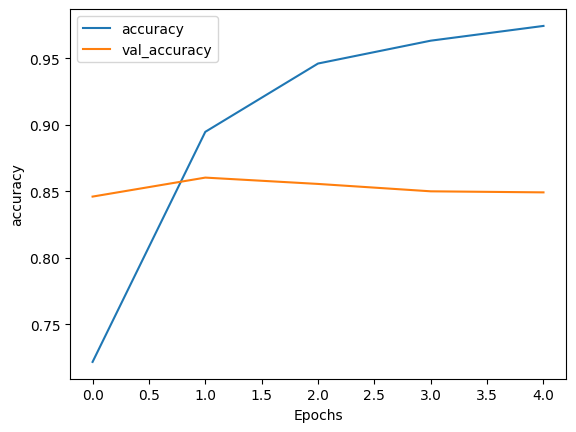

In [267]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

In [270]:
# Konversi probabilitas menjadi label sentimen
def convert_to_sentiment_label(probabilities):
    # Tentukan indeks dengan probabilitas tertinggi
    max_prob_index = np.argmax(probabilities)

    # Definisikan kelas sentimen berdasarkan indeks probabilitas tertinggi
    if max_prob_index == 0:
        return "Netral"
    elif max_prob_index == 1:
        return "Negatif"
    else:
        return "Positif"
    
# Kalimat untuk diuji
sentence = "ngentot lu jokowi"

# Lakukan transformasi TF-IDF pada kalimat
sentence_vectorized = vectorizer.transform([sentence]).toarray()

# Lakukan prediksi sentimen menggunakan model yang telah dilatih
prediction = model.predict(sentence_vectorized)    

# Konversi probabilitas menjadi label sentimen
sentiment_label = convert_to_sentiment_label(prediction[0])

# Tampilkan hasil prediksi
print("Sentimen:", sentiment_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sentimen: Negatif
